In [ ]:
import re
import requests
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

In [ ]:
pip install gluonts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 40.2 MB/s eta 0:00:00


In [ ]:
pip install mxnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 14.0 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.1
    Uninstalling graphviz-0.20.1:
      Successfully uninstalled graphviz-0.20.1


In [ ]:
from gluonts.dataset.field_names import FieldName
from gluonts.dataset.common import ListDataset
from gluonts.mx.model import deepar
from gluonts.mx.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator
from gluonts.model.predictor import Predictor

/usr/local/lib/python3.10/dist-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [ ]:
url = 'https://raw.githubusercontent.com/adecate/Deep-Generative-models-VaR/main/Data/commodities_dataset.csv'
open('commodities_dataset.csv', 'wb').write(requests.get(url).content)
commodities = pd.read_csv('commodities_dataset.csv')#, index_col='Date'


url = 'https://raw.githubusercontent.com/adecate/Deep-Generative-models-VaR/main/Data/stocks_dataset.csv'
open('stocks_dataset.csv', 'wb').write(requests.get(url).content);
stocks = pd.read_csv('stocks_dataset.csv')#, index_col='Date'

In [ ]:
def var_p(predictions, returns, weights, days_ahead=0, alpha=95):

    V = np.zeros(len(weights))
    for i in range(len(weights)):
        if weights[i] < 0 :
            V[i] = weights[i] * np.percentile(predictions[i].samples[:,days_ahead], alpha)
        else:
            V[i] = weights[i] * np.percentile(predictions[i].samples[:,days_ahead], 100-alpha)
    R = returns.corr()
    return -np.sqrt(V @ R @ V.T)

In [ ]:
weights = np.ones([15,1]) * 1/15

stocks['Date'] =  pd.to_datetime(stocks['Date'])
stocks['year'] = stocks['Date'].dt.year

stocks = stocks.set_index('Date')
stocks = stocks[stocks['year'] >= 2021]
stocks = stocks.drop(columns=['year'])

returns = stocks.pct_change().dropna()
returns = returns[returns.index>='2021-01-01']
returns.tail()

,AMD,NFLX,CVX,EA,LMT,PFE,HCA,MT,WMT,NKE,V,JNJ,SE,GE,RYCEY
Date,,,,,,,,,,,,,,,
2023-06-06,0.053422,-0.010532,0.001801,0.000945,0.008665,-0.007245,-0.003820,0.009811,-0.000134,0.009411,0.006394,-0.000884,0.045734,0.013064,0.005556
2023-06-07,-0.051517,0.001202,0.025932,-0.007079,0.006803,0.013552,0.008629,0.002616,0.001469,0.008475,-0.012926,0.002150,-0.005059,0.005879,0.005525
2023-06-08,0.027328,0.024014,-0.003691,0.006892,0.005241,0.005143,-0.000146,0.020127,0.014467,-0.008311,-0.009855,0.010976,0.042152,-0.000094,0.005495
2023-06-09,0.031970,0.026016,-0.002386,-0.009205,-0.003189,-0.003070,-0.006216,-0.002558,0.006046,-0.003201,0.002286,-0.001560,-0.002518,0.002168,0.000000
2023-06-12,0.034182,0.009404,-0.009631,-0.001429,-0.006095,0.023865,0.016373,0.000733,0.006597,0.009163,0.011675,-0.000687,0.026033,-0.000659,0.005464


In [ ]:
commodities['Date'] =  pd.to_datetime(commodities['Date'])
commodities['year'] = commodities['Date'].dt.year

commodities = commodities.set_index('Date')
commodities = commodities[commodities['year'] >= 2021]
commodities = commodities.drop(columns=['year'])

com_returns = commodities.pct_change().dropna()
com_returns = com_returns[com_returns.index>='2021-01-01']
com_returns.tail()

,GC=F,SI=F,HG=F,CL=F,NG=F,ZC=F,ZO=F,KE=F,ZS=F,HE=F,LE=F,CC=F,KC=F,CT=F,SB=F
Date,,,,,,,,,,,,,,,
2023-06-12,-0.003516,-0.014342,-0.010161,-0.043466,0.005324,0.021514,0.020921,-0.001567,-0.009917,-0.007966,0.004769,-0.013836,-0.026751,-0.006545,0.003546
2023-06-13,-0.005472,-0.009548,0.020797,0.034267,0.032657,-0.007695,0.030055,-0.005964,0.019304,-0.000574,0.001955,0.015944,-0.015090,-0.009223,-0.012171
2023-06-14,0.005502,0.012123,0.009795,-0.016566,0.000855,-0.007755,0.032493,-0.007578,-0.007861,0.000861,-0.011007,0.000942,0.009029,-0.011243,0.027027
2023-06-15,0.001279,-0.006363,0.007889,0.034422,0.081554,0.025504,0.035967,0.034362,0.028813,0.054186,-0.037053,0.020383,-0.006508,-0.014060,-0.008127
2023-06-16,0.008428,0.006655,0.003336,0.001133,0.011449,-0.073004,0.021079,-0.001230,-0.087170,0.000000,0.000000,0.000000,0.000000,0.015377,0.000000


In [ ]:
class DeepARModel:
    def __init__(self, freq='1D', context_length=15, prediction_length=10,
                 epochs=2, learning_rate=1e-4, n_layers=5., dropout=0.1):

        self.freq = freq
        self.context_length = context_length
        self.prediction_length = prediction_length
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.n_layers = n_layers
        self.dropout = dropout

    def df_to_np(self, ts):
        return ts.to_numpy().T

    def list_dataset(self, ts, train=True):
        custom_dataset = self.df_to_np(ts)
        start = pd.Timestamp(ts.index[0], freq=self.freq)
        if train == True:
            ds = ListDataset([{'target': x, 'start': start}
                              for x in custom_dataset[:, :-self.prediction_length]],
                             freq=self.freq)
        else:
            ds = ListDataset([{'target': x, 'start': start}
                              for x in custom_dataset],
                             freq=self.freq)
        return ds

    def fit(self, ts):
        estimator = deepar.DeepAREstimator(
            prediction_length=self.prediction_length,
            context_length=self.context_length,
            freq=self.freq,
            trainer=Trainer(epochs=self.epochs,
                            ctx="cpu",
                            learning_rate=self.learning_rate,
                            num_batches_per_epoch=50,
                            ),
            num_layers=self.n_layers,
            dropout_rate=self.dropout,
            cell_type='lstm',
            num_cells=50
        )
        list_ds = self.list_dataset(ts, train=True)
        predictor = estimator.train(list_ds)
        return predictor

    def predict(self, ts ):
        test_ds = self.list_dataset(ts, train=False)
        return self.estimator.predict(test_ds, num_samples=1000)



def make_forecasts(predictor, test_data, n_sampl):
    forecasts = []
    tss = []
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_data,
        predictor=predictor,
        num_samples=n_sampl
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)
    return forecasts, tss


In [ ]:
from scipy.stats import chi2
def pof_test(var, target, alpha=0.998):
    exception = target < var
    t = len(target)
    m = exception.sum()
    nom = (1 - alpha)**m * alpha**(t-m)
    den = (1 - m/t)**(t - m) * (m / t)**m
    pof_test = -2 * np.log(nom / den)
    pvalue = 1 - chi2.cdf(pof_test, df=1)
    return pvalue

def if_test(var, target):
    exception = target < var
    pairs = [(exception[i], exception[i+1]) for i in range(len(exception) - 1)]
    pairs = np.array(pairs).astype('int')
    n00 = ((pairs[:, 0] == 0) & (pairs[:, 1] == 0)).sum()
    n01 = ((pairs[:, 0] == 0) & (pairs[:, 1] == 1)).sum()
    n10 = ((pairs[:, 0] == 1) & (pairs[:, 1] == 0)).sum()
    n11 = ((pairs[:, 0] == 1) & (pairs[:, 1] == 1)).sum()
    pi = (n01 + n11) / (n00 + n01 + n10 + n11)
    pi0 = n01 / (n00 + n01)
    pi1 = n11 / (n10 + n11)
    nom = (1 - pi)**(n00 + n10) * pi**(n01 + n11)
    den = (1 - pi0)**n00 * pi0**n01 * (1 - pi1)**n10 * pi1**n11
    if_test = -2 * np.log(nom / den)
    pvalue = 1 - chi2.cdf(if_test, df=1)
    return pvalue

def tests(df):
    print("%.2f" % pof_test(df['VaR'], df['Change']))
    print("%.2f" % if_test(df['VaR'], df['Change']))

In [ ]:
# from google.colab import files
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def deepvar(returns):
    estimator = DeepARModel(prediction_length=1,  context_length=15, epochs=5).fit(returns)
    predictions_it = estimator.predict(DeepARModel().list_dataset(returns, train=False), 1000)
    predictions = list(predictions_it)
    return var_p(predictions,returns, weights, 0, alpha=99)

# Stocks

In [ ]:
w = 200

i = w
portf = returns.copy()
var_values = pd.DataFrame({'Date': [], 'VaR': []})
breakdowns  = pd.DataFrame({'Date': [], 'value': []})

while i <=returns.shape[0] - 1:
    var_values = pd.concat([var_values, pd.DataFrame({'Date': [portf[i:i+1].index.date[0]], 'VaR': [deepvar(portf[i-w:i])]})])
    i+=1

var_values.to_csv('deepvar_vals.csv')
files.download('deepvar_vals.csv')

In [ ]:
dv = pd.read_csv('deepvar_vals.csv')

In [ ]:
dv

,Date,VaR
0,2021-10-20,-0.025634
1,2021-10-21,-0.021166
2,2021-10-22,-0.025688
3,2021-10-25,-0.018602
4,2021-10-26,-0.021070
...,...,...
310,2023-06-06,-0.040365
311,2023-06-07,-0.033873
312,2023-06-08,-0.040171
313,2023-06-09,-0.035913


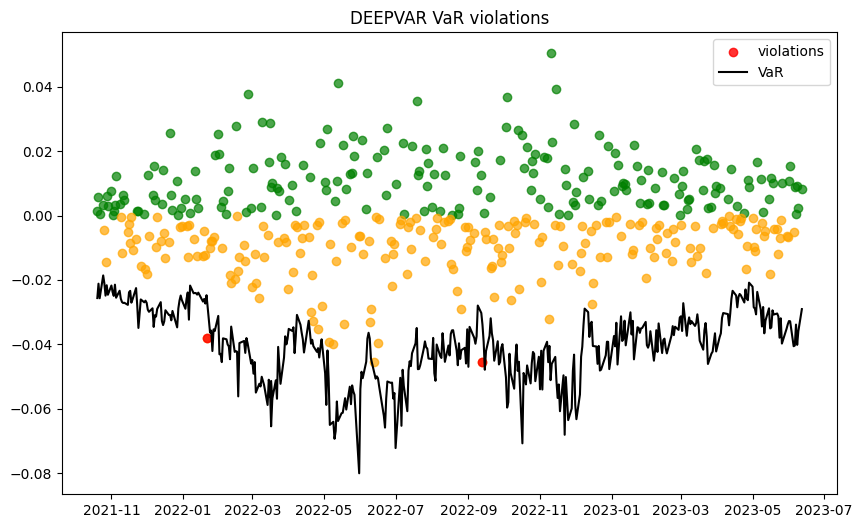

In [ ]:
portf= returns[200:].dot(weights)
fig, ax = plt.subplots(figsize=(10, 6))
pos = portf[portf.apply(lambda x: x >= 0)]
neg = portf[portf.apply(lambda x: x <  0)]

dv['Date'] = pd.to_datetime(dv['Date'])
var_df = dv.merge(portf.reset_index(), on='Date')
var_df.columns = ['Date', 'VaR', 'Change']
var_df['Violation'] = (var_df['Change'] < var_df['VaR'])

breakdowns = var_df[var_df['Violation'] == 1]


plt.scatter(pos.index,pos, c = 'green', alpha = 0.7)
plt.scatter(neg.index,neg, c = 'orange', alpha = 0.7)
plt.scatter(breakdowns.Date, breakdowns.Change, c = 'red', alpha = 0.8,  label = 'violations')
plt.plot(dv.Date, dv.VaR, label = 'VaR', c = 'black')
plt.legend()
plt.title("{} VaR violations".format(deepvar.__name__.upper()))
plt.show();

In [ ]:
tests(var_df)

0.28
0.89


# Commodities

In [ ]:
w = 200

i = w
portf = com_returns.copy()
var_values = pd.DataFrame({'Date': [], 'VaR': []})

while i <=com_returns.shape[0] - 1:
    var_values = pd.concat([var_values, pd.DataFrame({'Date': [portf[i:i+1].index.date[0]], 'VaR': [deepvar(portf[i-w:i])]})])
    i+=1

var_values.to_csv('deepvar_vals_coms.csv')
files.download('deepvar_vals_coms.csv')

In [ ]:
dv = pd.read_csv('deepvar_vals_coms.csv')

In [ ]:
dv

,Date,VaR
0,2021-10-20,-0.027294
1,2021-10-21,-0.027983
2,2021-10-22,-0.026804
3,2021-10-25,-0.029873
4,2021-10-26,-0.030425
...,...,...
413,2023-06-09,-0.026189
414,2023-06-12,-0.029084
415,2023-06-13,-0.026579
416,2023-06-14,-0.028192


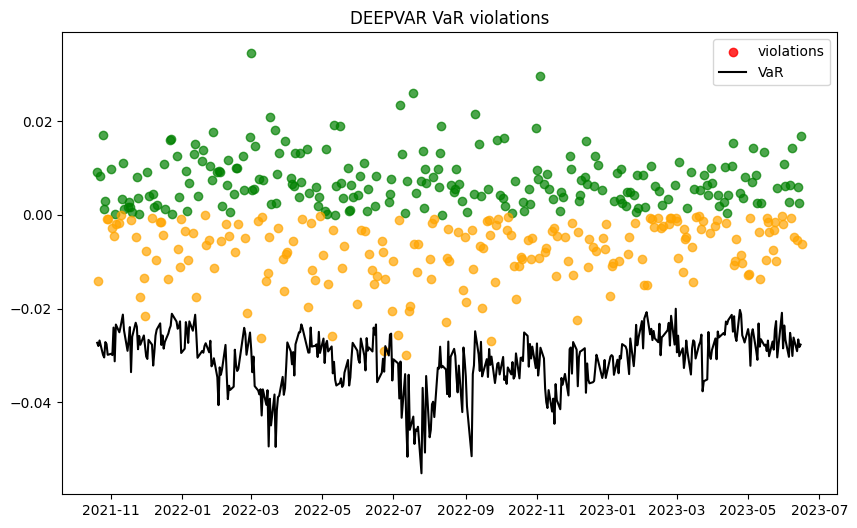

In [ ]:
portf= com_returns[200:].dot(weights)
fig, ax = plt.subplots(figsize=(10, 6))
pos = portf[portf.apply(lambda x: x >= 0)]
neg = portf[portf.apply(lambda x: x <  0)]

dv['Date'] = pd.to_datetime(dv['Date'])
var_df = dv.merge(portf.reset_index(), on='Date')
var_df.columns = ['Date', 'VaR', 'Change']
var_df['Violation'] = (var_df['Change'] < var_df['VaR'])

breakdowns = var_df[var_df['Violation'] == 1]


plt.scatter(pos.index,pos, c = 'green', alpha = 0.7)
plt.scatter(neg.index,neg, c = 'orange', alpha = 0.7)
plt.scatter(breakdowns.Date, breakdowns.Change, c = 'red', alpha = 0.8,  label = 'violations')
plt.plot(dv.Date, dv.VaR, label = 'VaR', c = 'black')
plt.legend()
plt.title("{} VaR violations".format(deepvar.__name__.upper()))
plt.show();

In [ ]:
tests(var_df)

0.20
1.00


<ipython-input-19-2eebef31b1a0>:22: RuntimeWarning: invalid value encountered in long_scalars
  pi1 = n11 / (n10 + n11)
